In [20]:
import os.path

import numpy as np
import random
seed = 42
random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

import mne
from mne import find_events
from mne.decoding import Vectorizer, SlidingEstimator, cross_val_multiscore

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import import_ipynb
from CommonFunctions import loadData, extractDataAndLabels, concatNonEmpty, prepareData_conf_behavior, prepareData_pred_behavior_conf, splitEpochs_byConfidence, loadDataByParticipant

import pylab
import seaborn as sns
from scipy.stats import sem


In [21]:
sensors = 'mag'

#File paths
meg_MainFolder = "..\Data\MEG_Data\Data="
figures_MainFolder = "..\Figures\MVPA\Data="
results_MainFolder = "..\Results\Data="
classifiers_MainFolder = "..\Classifiers\Data="

tmin, tmax = -0.1, 0.6

# Decide the time limit based on the time range of the data
tlim = 0
if float(tmin) == -0.8:
    tlim = 140
elif float(tmin) == -0.1:
    tlim = 70

print('tmin = ', tmin)
print('tmax = ', tmax)
print('tlim = ', tlim)

dataFolder = meg_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Data folder: ', dataFolder)

figuresFolder = figures_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Figures folder: ', figuresFolder)

results_folder = results_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Results folder: ', results_folder)

clsfFolder = classifiers_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Classifiers folder: ', clsfFolder)



filename_ext = ''
if tmin == -0.8 and tmax == 0.6:
    filename_ext = '-elongated'
elif tmin == -0.8 and tmax == 1:
    filename_ext = '-elongated_2'
    
print('filename ext: ', filename_ext)

task_name = 'all_predLevel' #"all_predLevel" #'all_incorrVScorr'# 'all_conf' #behavior_conf #conf_pred #behavior_conf_pred
print('Task name: ', task_name)

reversedLabels = False

if tmin == -0.1:
    # Shorter time interval
    w = [20, 50] 
else:
    # long time interval
    w = [90,120]
    
print('Time interval of the training: ', w)

s_id_list = ['13', '16', '17', '18', '21', '23', '26', '28', '29', '30', '31', '32', '33', 
         '34', '35', '36', '38', '39', '40', '41', '42']

#s_id_list = ['23', '26', '30', '31', '34', '35', '38', '39']
print('Number of subjects: ', len(s_id_list))

#s_id_list_corrected = ['23', '26', '30', '31', '34', '35', '38', '39']
#print('Number of subjects whose triggers are corretcted: ', len(s_id_list_corrected))

tmin =  -0.1
tmax =  0.6
tlim =  70
Data folder:  ..\Data\MEG_Data\Data=-0.1_0.6\
Figures folder:  ..\Figures\MVPA\Data=-0.1_0.6\
Results folder:  ..\Results\Data=-0.1_0.6\
Classifiers folder:  ..\Classifiers\Data=-0.1_0.6\
filename ext:  
Task name:  all_predLevel
Time interval of the training:  [20, 50]
Number of subjects:  21


In [22]:
results_all = []
for s in range(len(s_id_list)):
    
    s_id = s_id_list[s]
    outputfilename = results_folder + 'S' + s_id + '\\' + s_id + "_" + sensors + "_results_" + task_name +"_" + str(w[0]) + '_' + str(w[1])+ '_sm_all.npy'
    res = np.load(outputfilename, allow_pickle=True)
    results_all.append(res)

In [23]:
results_all = np.asarray(results_all)

In [24]:
results_all

(21, 5)

In [13]:
# Load one subjects epoch data to use times
s_id = '17'
fname = dataFolder+'S'+s_id+'\\'+s_id+'_2_tsss_mc_trans_'+sensors+'_nobase-epochs_afterICA'+filename_ext+'_manually_AR_resampled.fif'
epochs = mne.read_epochs(fname)    

Reading ..\Data\MEG_Data\Data=-0.1_0.6\S17\17_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR_resampled.fif ...
    Found the data of interest:
        t =    -100.00 ...     590.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
873 matching events found
No baseline correction applied
0 projection items activated


In [14]:
trainedAlready=True
print("is trained already: ", trainedAlready)
print('Task name: ', task_name)

if 'incorrVScorr' in task_name:
    isBehavior = True
else:
    isBehavior = False
    
print('Is behavior?: ', isBehavior)

if task_name == "all_predLevel":
    plot_labels = ['80%', '90%', '100%']
    plot_file_suf = ['80', '90', '100']
    
elif task_name == "behavior_conf":
    plot_labels = ['Corr & Low', 'Corr & High','Incorr & Low', 'Incorr & High']
    plot_file_suf = ['corrLow', 'corrHigh', 'incorrLow', 'incorrHigh']
    
elif task_name == 'all_incorrVScorr':
    plot_labels = ['Correct', 'Incorrect']
    plot_file_suf = ['corr', 'incorr']
    
elif task_name == "all_conf":
    plot_labels = ['Low Confidence', 'High Confidence']
    plot_file_suf = ['lowConf', 'highConf']
    
elif task_name == "conf_pred":
    plot_labels = ['80% - Low', '90% - Low', '100% - Low', '80% - High', '90% - High', '100% - High']
    plot_file_suf = ['low_8', 'low_9', 'low_10', 'high_8', 'high_9', 'high_10']

elif task_name == "behavior_conf_pred":
    plot_labels = ['80% - Corr & LowConf', '90% - Corr & LowConf', '100% - Corr & LowConf',
                   '80% - Incorr & LowConf', '90% - Incorr & LowConf', '100% - Incorr & LowConf',
                   '80% - Corr & HighConf', '90% - Corr & HighConf', '100% - Corr & HighConf',
                   '80% -Incorr & HighConf', '90% - Incorr & HighConf', '100% - Incorr & HighConf']
    plot_file_suf = ['8_corrLow', '9_corrLow', '10_corrLow', '8_incorrLow', '9_incorrLow', '10_incorrLow',
                     '8_corrHigh', '9_corrHigh', '10_corrHigh', '8_incorrHigh', '9_incorrHigh', '10_incorrHigh']
    
print('Plot labels: ', plot_labels)

is trained already:  True
Task name:  all_predLevel
Is behavior?:  False
Plot labels:  ['80%', '90%', '100%']


In [15]:
def applySmoothing(data, N):
    # Initialize smoothed data variable
    data_sm = np.zeros((data.shape[0], data.shape[1]-N+1))
            
    #print('shape of data at 0: ', data_0.shape)
    #print('shape of data_sm_0: ', data_sm_0.shape)

    # Apply smoothing:
    for f in range(len(data_sm)):
        data_sm[f] = np.convolve(data[f,:], np.ones((N,))/N, mode='valid')
    
    return data_sm
    

In [25]:
test_real_res = np.zeros((len(s_id_list), len(epochs.times)),)
for i in range(test_real_res.shape[0]):
    test_real_res[i,:] = results_all[i,0]

N = 10
test_real_res_sm =test_real_res # applySmoothing(test_real_res, N)
times_sm = epochs.times#[:len(epochs.times)-N+1]
group_avg_real = np.mean(test_real_res_sm, axis=0)
group_std_real = sem(test_real_res_sm, axis=0, nan_policy='omit')/2

In [27]:
test_real_res.shape

np.save(results_folder+'real_sounds_testResults_overTimeRange', test_real_res)

In [17]:
from scipy.stats import wilcoxon
p_threshold = 0.05
print('p value threshold: ', p_threshold)
nt = len(times_sm)
preal = np.ones(nt)
chance = 0.5
for t in np.arange(nt):
    x, preal[t] = wilcoxon(test_real_res_sm[:,t]-chance, alternative='greater')
    
print('\nP values: ', preal)

max_score = np.max(group_avg_real)
time_max_score = times_sm[np.where(group_avg_real == max_score)[0].tolist()]
print('\nMaximum score of ' + str(max_score)+' achieved at ' + str(time_max_score))

from mne.stats import bonferroni_correction
r,p_corrected = mne.stats.bonferroni_correction(preal)
print('P values before the correction: ', preal)
print('P values after the correction: ', p_corrected)

times_sig_wo_corr = times_sm[np.where(preal<= p_threshold)[0].tolist()]
print('\nSignificant time points before correction: ', times_sig_wo_corr)

times_sig = times_sm[np.where(p_corrected <= p_threshold)[0].tolist()]
print('\nSignificant time points after correction: ', times_sig)


p value threshold:  0.05

P values:  [9.99988079e-01 9.99853611e-01 9.99199867e-01 9.99412060e-01
 9.99947548e-01 9.99984264e-01 9.99997616e-01 1.00000000e+00
 9.99879360e-01 9.99995232e-01 9.99744892e-01 9.99996662e-01
 9.99199867e-01 9.94937420e-01 9.99947548e-01 9.99639511e-01
 9.99744892e-01 1.00000000e+00 9.99997616e-01 9.99999523e-01
 9.99988079e-01 9.97229099e-01 9.99412060e-01 9.98123646e-01
 7.84044266e-01 1.87635422e-03 7.08293915e-03 4.50801849e-03
 6.34574890e-03 4.50801849e-03 3.79900932e-02 1.75280571e-02
 4.25815582e-04 1.57356262e-05 2.38418579e-06 1.43051147e-06
 4.76837158e-07 4.76837158e-07 2.38418579e-06 2.38418579e-06
 9.53674316e-07 9.53674316e-07 4.76837158e-07 4.76837158e-07
 4.76837158e-07 4.76837158e-07 4.76837158e-07 1.57356262e-05
 2.55107880e-04 9.29355621e-04 8.00132751e-04 1.51907921e-01
 4.59346771e-01 7.63332844e-01 9.91226673e-01 9.53518437e-01
 9.77003574e-01 9.94937420e-01 9.99966621e-01 9.99958038e-01
 1.00000000e+00 9.99988079e-01 9.99995232e-01 9.

TIme between two time points:  0.01
Significant time points exist!
the end of computation!
Significant time intervals:  [[0.22, 0.38]]


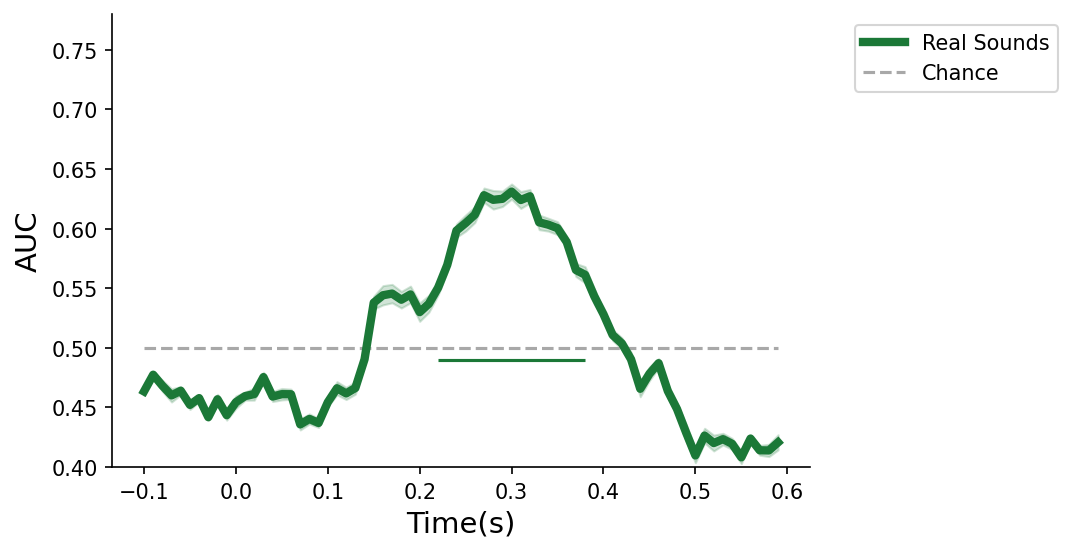

In [19]:
color = np.array((27,120,55))/256
color_chanceLevel = np.array((169,169,169))/256

al = 0.2
font_size = 14

fig = plt.figure(num=None, figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1,1,1)

plt.plot(times_sm, group_avg_real, color = color, linewidth = 4, label='Real Sounds')
plt.fill_between(times_sm, group_avg_real, group_avg_real + group_std_real, color=color,
                 interpolate=True, alpha = al)
plt.fill_between(times_sm, group_avg_real, group_avg_real - group_std_real, color=color,
                 interpolate=True, alpha = al)

plt.xlabel('Time(s)', fontsize=font_size)
plt.ylabel('AUC', fontsize=font_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


timeInterval = 0.01
print('TIme between two time points: ', timeInterval)

if len(times_sig)>0:
    times_sig_periods = []
    print('Significant time points exist!')
    
    # Computet the time periods that are significcantt
    start, end = None, None
    for k in range(len(times_sig)):
        if k == 0:
            start = times_sig[k]
            if len(times_sig) == 1: # if we have only 1 time point that is significant
                end = times_sig[k]
                times_sig_periods.append([start,end])
        else:
            if round(times_sig[k],2) != round(times_sig[k-1] + timeInterval, 2): # if the data points are not continuous
                end =  times_sig[k-1]
                times_sig_periods.append([start,end])
                start = times_sig[k]
            else:
                if k == len(times_sig)-1:
                    print('the end of computation!')
                    end = times_sig[k]
                    times_sig_periods.append([start,end])

                
    print('Significant time intervals: ', times_sig_periods) 
    
    for p in range(len(times_sig_periods)):
        if times_sig_periods[p][0] == times_sig_periods[p][1]:
            print('Here')
            ax.plot(times_sig_periods[p][0], 0.49)
        else:
            ax.hlines(xmin=times_sig_periods[p][0], xmax=times_sig_periods[p][1], y=0.49, color=color, linestyle='-')
    
    ax.hlines(xmin=times_sm[0], xmax=times_sm[-1], y=0.5, color=color_chanceLevel, linestyle='--', label='Chance')
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_ylim(0.4, 0.78)
    #plt.setp(ax.spines.values(), linewidth=1)
    #ax.tick_params(bottom=True, length=5, left=True)
    plt.savefig(figures_MainFolder+'Group_Level_real_sounds_overTimeMVPA_bonfr_crr'+str(p_threshold)+'_noSM.png',
                bbox_inches='tight')
   